# NHL GM/Coach Insights

*Introduction to dataset*

The NHL Game dataset comes from kaggle.com (https://www.kaggle.com/martinellis/nhl-game-data).
It has in-depth statistics on games from the past 6 years (not including the 2018/19 season). The stats can be as macro as total games stats, or as micro as each different shift and their results or each play done by a player (a hit, shot, etc). We decided to focus on the overall team stats and player stats for each game.

currentVenues.csv and outdoorArenas.csv were scrapped from Wikipedia as venues that have been played at in the previous 6 years.

*Notes on rows and columns*

Each row and column is different for each .csv file. For the game_player_stats.csv, each row represents the player's stats for each game they played, and the rows tell the total statistics of that game. For the game_team_stats.csv, each row represents the stats that are tracked for the overall team per game. 

For both csv's, the game_id is used to note which game they had the stats in so we can easily figure out who they played against, and with the currentArenas.csv file, we can note where they played as well due to the home or away column in both the player and team files.

All other columns have straight forward names that describe what they describe.

*Note on assists: Assists are not exclusively the last player on the same team to pass the puck to the scorer, but also the player who passed the puck to the primary assister (aka secondary assist), though not all goals have a secondary or even primary assists.*

*Time On Ice is measured in seconds and not minutes* 

*A lot of the columns were dropped to to not needing them at all and not being relevant to the insights. Tables were made and shown showing the most pertinent columns and info.*

*Notes on terminology necessary*

Power play: When one team has a player advantage because one or two members of the other team have been sent to the penalty box for committing a penalty (either for 2 minutes (minor) or 4 minutes (double minor)).

Short handed: When one team has fewer player than the other team due to a power play.

Even-strength: When both teams have the same number of players on the ice.

Plus/minus: A player is awarded a plus when he is on the ice for an even-strength or shorthanded goal and is awarded a minus when he is on the ice for an even-strength or shorthanded goal by the opponent.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image
import pydotplus

import sklearn as sk
import warnings 
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**dfP will hold the information in player_info.csv, and will be cleaned for merging below**

In [3]:
dfP = pd.read_csv('player_info.csv')

In [4]:
dfP.columns.tolist()

['player_id',
 'firstName',
 'lastName',
 'nationality',
 'birthCity',
 'primaryPosition',
 'birthDate',
 'link']

In [5]:
dfP.drop(['link', 'birthCity'], axis = 1,\
              inplace=True)

In [6]:
dfP.head()

,player_id,firstName,lastName,nationality,primaryPosition,birthDate
0,8467412,Alexei,Ponikarovsky,UKR,LW,1980-04-09
1,8468501,Anton,Volchenkov,RUS,D,1982-02-25
2,8459670,Kimmo,Timonen,FIN,D,1975-03-18
3,8471233,Travis,Zajac,CAN,C,1985-05-13
4,8455710,Martin,Brodeur,CAN,G,1972-05-06


In [7]:
dfP['Name'] = dfP.firstName + '_' + dfP.lastName

In [8]:
dfP.head()

,player_id,firstName,lastName,nationality,primaryPosition,birthDate,Name
0,8467412,Alexei,Ponikarovsky,UKR,LW,1980-04-09,Alexei_Ponikarovsky
1,8468501,Anton,Volchenkov,RUS,D,1982-02-25,Anton_Volchenkov
2,8459670,Kimmo,Timonen,FIN,D,1975-03-18,Kimmo_Timonen
3,8471233,Travis,Zajac,CAN,C,1985-05-13,Travis_Zajac
4,8455710,Martin,Brodeur,CAN,G,1972-05-06,Martin_Brodeur


In [9]:
dfP.drop(['firstName', 'lastName'], axis = 1, inplace = True)

In [10]:
len(dfP)

2246

In [11]:
dfP.isna().any()

player_id          False
nationality         True
primaryPosition    False
birthDate          False
Name               False
dtype: bool

In [12]:
dfP.isna().sum()

player_id          0
nationality        4
primaryPosition    0
birthDate          0
Name               0
dtype: int64

In [13]:
dfP.fillna("Unknown", inplace=True)

In [14]:
dfP.isna().sum().sum()

0

In [15]:
dfP.nationality.nunique()

26

In [16]:
dfP.primaryPosition.nunique()

5

In [17]:
dfP.birthDate = dfP.birthDate\
  .apply(lambda x:int(pd.to_datetime('today').year - pd.to_datetime(x).year))

In [18]:
dfP.rename(columns={'birthDate':'age'}, inplace=True)

**dfP is now cleaned and ready**

**dfT will hold the information in player_info.csv, and will be cleaned for merging below**

In [19]:
dfT = pd.read_csv('team_info.csv')

In [20]:
dfT.columns.tolist()

['team_id', 'franchiseId', 'shortName', 'teamName', 'abbreviation', 'link']

In [21]:
dfT.drop(['franchiseId', 'teamName', 'abbreviation', 'link'], axis=1,\
             inplace=True)

In [22]:
dfT.isna().any()

team_id      False
shortName    False
dtype: bool

In [23]:
dfT.shortName.nunique()

33

In [24]:
dfT.rename(columns={'shortName':'teamName'}, inplace=True)

**dfT is now cleaned and ready**

**dfG will hold the information in game.csv, and will be cleaned for merging below**

In [25]:
dfG = pd.read_csv('game.csv')

In [26]:
dfG.columns.tolist()

['game_id',
 'season',
 'type',
 'date_time',
 'away_team_id',
 'home_team_id',
 'away_goals',
 'home_goals',
 'outcome',
 'home_rink_side_start',
 'venue',
 'venue_link',
 'venue_time_zone_id',
 'venue_time_zone_offset',
 'venue_time_zone_tz']

In [27]:
dfG.drop(['season', 'away_goals','home_goals', 'home_rink_side_start',\
              'venue_link','venue_time_zone_id', 'venue_time_zone_offset',\
              'venue_time_zone_tz', 'outcome', 'home_team_id',\
              'away_team_id'], axis=1, inplace=True)

In [28]:
dfG.head()

,game_id,type,date_time,venue
0,2012030221,P,2013-05-16T23:30:00Z,TD Garden
1,2012030222,P,2013-05-19T19:00:00Z,TD Garden
2,2012030223,P,2013-05-21T23:30:00Z,Madison Square Garden
3,2012030224,P,2013-05-23T23:00:00Z,Madison Square Garden
4,2012030225,P,2013-05-25T21:30:00Z,TD Garden


In [29]:
len(dfG)

7441

In [30]:
dfG.isna().any()

game_id      False
type         False
date_time    False
venue        False
dtype: bool

In [31]:
dfG.type.nunique()

2

In [32]:
dfG.venue.nunique()

65

In [33]:
dfG['venue'] = dfG.venue.apply(lambda x: x.strip())

In [34]:
dfG.venue.nunique()

61

In [35]:
currentArenas = pd.read_csv('currentArenas.csv')

In [36]:
currentArenas2 = pd.read_csv('currentArenas.csv')

In [37]:
currentArenas2.head()

,Image,Arena,Location,Team(s),Capacity,Opened,Season of first NHL game,Ref(s)
0,NaN,Amalie Arena,"Tampa, Florida",Tampa Bay Lightning,"19,092",1996,1996–97,[1]
1,NaN,American Airlines Center,"Dallas, Texas",Dallas Stars,"18,532",2001,2001–02,[2]
2,NaN,BB&T Center,"Sunrise, Florida",Florida Panthers,"19,250",1998,1998–99,[3]
3,NaN,Barclays Center,"Brooklyn, New York",New York Islanders,"15,795",2012,2015–16,[4]
4,NaN,Nassau Coliseum,"Uniondale, New York",New York Islanders,"13,900",1972,1972–732018–19 (return),[5]


In [38]:
currentArenas.columns

Index(['Image', 'Arena', 'Location', 'Team(s)', 'Capacity', 'Opened', 'Season of first NHL game', 'Ref(s)'], dtype='object')

In [39]:
currentArenas.drop(['Image', 'Team(s)', 'Capacity', 'Opened',\
            'Season of first NHL game', 'Ref(s)'], axis=1, inplace=True)

In [40]:
currentArenas.head()

,Arena,Location
0,Amalie Arena,"Tampa, Florida"
1,American Airlines Center,"Dallas, Texas"
2,BB&T Center,"Sunrise, Florida"
3,Barclays Center,"Brooklyn, New York"
4,Nassau Coliseum,"Uniondale, New York"


In [41]:
currentArenas.Arena.nunique()

32

In [42]:
count = 0
for x in currentArenas.Arena.tolist():
    if x in dfG.venue.unique().tolist():
        count = count + 1
print(count)

28


In [43]:
for x in currentArenas.Arena.tolist():
    if x not in dfG.venue.unique().tolist():
        print(x)

Bell Centre
Enterprise Center
Scotiabank Arena
SAP Center


In [44]:
for x in dfG.venue.unique().tolist():
    if 'Bell' in x and 'Centre' in x:
        print('Bell Centre: ' + x)
    if 'SAP' in x and 'Center' in x:
        print('SAP Center: ' + x)

Bell Centre: Centre Bell
SAP Center: SAP Center at San Jose


In [45]:
for x in dfG.venue.unique().tolist():
    if 'Scottrade' in x and 'Center' in x:
        print('Enterprise Center: ' + x)
    if 'Air' in x and 'Canada' in x:
        print('Scotiabank Arena: ' + x)

Enterprise Center: Scottrade Center
Scotiabank Arena: Air Canada Centre


In [46]:
currentArenas.Arena.replace(to_replace=['Bell Centre', 'Enterprise Center',\
                'Scotiabank Arena', 'SAP Center'], value=['Centre Bell',\
                'Scottrade Center', 'Air Canada Centre', 'SAP Center at San Jose'],\
                inplace=True)

In [47]:
count = 0
for x in currentArenas.Arena.tolist():
    if x not in dfG.venue.unique().tolist():
        count = count + 1
print(count)

0


In [48]:
outdoorVenues = pd.read_csv('outdoorVenues.csv')

In [49]:
outdoorVenues.drop(['Host Team', 'Event', 'Year used', 'Attendance',\
                    'Ref(s)'], axis=1, inplace=True)

In [50]:
venueLocations = pd.concat([currentArenas, outdoorVenues])

In [51]:
test = dfG.merge(venueLocations, left_on='venue', right_on='Arena', how='left')

In [52]:
test.isna().sum()

game_id         0
type            0
date_time       0
venue           0
Arena        1434
Location     1434
dtype: int64

In [53]:
test[test.isnull().any(axis=1)].venue.nunique()

15

In [54]:
test[test.isnull().any(axis=1)].venue.unique()

array(['CONSOL Energy Center', 'Joe Louis Arena', 'Scotiabank Place',
       'Verizon Center', 'HP Pavilion at San Jose', 'STAPLES Center',
       'MTS Centre', 'Tampa Bay Times Forum', 'Jobing.com Arena',
       'First Niagara Center', 'Rexall Place', 'The Big House',
       'Ericsson Globe', 'Lansdowne Park',
       'Navy-Marine Corps Memorial Stadium'], dtype=object)

In [55]:
dOtherVenues = {'Arena': ['CONSOL Energy Center', 'Joe Louis Arena', 'Scotiabank Place','Verizon Center',\
                          'HP Pavilion at San Jose', 'STAPLES Center', 'MTS Centre', 'Tampa Bay Times Forum',\
                          'Jobing.com Arena', 'First Niagara Center', 'Rexall Place', 'The Big House', 'Ericsson Globe',\
                          'Lansdowne Park', 'Navy-Marine Corps Memorial Stadium'],\
                'Location': ['Pittsburgh, Pennsylvania', 'Detroit, Michigan', 'Ottawa, Ontario','Washington, D.C.',\
                             'San Jose, California', 'Los Angeles, California','Winnipeg, Manitoba', 'Tampa, Florida',\
                             'Glendale, Arizona', 'Buffalo, New York','Edmonton, Alberta', 'Ann Arbor, MI',\
                             'Stockholm, Sweden','Ottawa, Ontario', 'Annapolis, Maryland']}
dfOtherVenues = pd.DataFrame(data=dOtherVenues)

In [56]:
venueLocations = pd.concat([venueLocations, dfOtherVenues])

In [57]:
dfG = dfG.merge(venueLocations, left_on='venue', right_on='Arena', how='left')

In [58]:
dfG.drop('Arena', axis=1, inplace=True)

In [59]:
dfG.rename(columns={'Location':'venueLocation'}, inplace=True)

In [60]:
dfG.isna().sum()

game_id          0
type             0
date_time        0
venue            0
venueLocation    0
dtype: int64

**dfG is now cleaned and ready**

**dfGTS will hold the information in game_teams_stats.csv, and will be cleaned for merging below**

In [61]:
dfGTS = pd.read_csv('game_teams_stats.csv')

In [62]:
dfGTS.columns.tolist()

['game_id',
 'team_id',
 'HoA',
 'won',
 'settled_in',
 'head_coach',
 'goals',
 'shots',
 'hits',
 'pim',
 'powerPlayOpportunities',
 'powerPlayGoals',
 'faceOffWinPercentage',
 'giveaways',
 'takeaways']

In [63]:
dfGTS.drop(['head_coach', 'goals', 'shots', 'hits', 'pim',\
           'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',\
          'giveaways', 'takeaways'], axis=1, inplace=True)

In [64]:
dfGTS.head()

,game_id,team_id,HoA,won,settled_in
0,2012030221,3,away,False,OT
1,2012030221,6,home,True,OT
2,2012030222,3,away,False,REG
3,2012030222,6,home,True,REG
4,2012030223,6,away,True,REG


In [65]:
len(dfGTS)

14882

In [66]:
dfGTS.isna().any()

game_id       False
team_id       False
HoA           False
won           False
settled_in    False
dtype: bool

In [67]:
dfGTS.HoA.nunique()

2

In [68]:
dfGTS.settled_in.nunique()

3

**dfGT is now cleaned and ready**

**dfGSS will hold the information in game_skater_stats.csv, and will be prepared for merging below**

In [69]:
dfGSS = pd.read_csv('game_skater_stats.csv')

In [70]:
dfGSS.columns.tolist()

['game_id',
 'player_id',
 'team_id',
 'timeOnIce',
 'assists',
 'goals',
 'shots',
 'hits',
 'powerPlayGoals',
 'powerPlayAssists',
 'penaltyMinutes',
 'faceOffWins',
 'faceoffTaken',
 'takeaways',
 'giveaways',
 'shortHandedGoals',
 'shortHandedAssists',
 'blocked',
 'plusMinus',
 'evenTimeOnIce',
 'shortHandedTimeOnIce',
 'powerPlayTimeOnIce']

In [71]:
dfGSS.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce
0,2012030221,8471958,3,1925,0,0,0,3,0,0,0,0,0,1,0,0,0,5,0,1406,342,177
1,2012030221,8471339,3,1597,1,0,2,3,0,0,0,0,0,1,3,0,0,2,1,1099,315,183
2,2012030221,8471873,3,1695,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,1488,99,108
3,2012030221,8473432,3,957,0,0,3,5,0,0,2,0,0,0,1,0,0,0,0,957,0,0
4,2012030221,8470192,3,859,0,0,1,0,0,0,2,0,0,1,0,0,0,2,0,859,0,0


In [72]:
len(dfGSS)

267854

**dfGSS is now ready for merging**

**dfNHL will hold the combined information of all previous dataframes**

In [73]:
dfNHL = dfGSS.merge(dfP, on='player_id')

In [74]:
dfNHL = dfNHL.merge(dfT, on='team_id')

In [75]:
dfNHL = dfNHL.merge(dfG, on='game_id')

In [76]:
dfNHL = dfNHL.merge(dfGTS, on=['game_id', 'team_id'])

In [77]:
dfNHL.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,nationality,primaryPosition,age,Name,teamName,type,date_time,venue,venueLocation,HoA,won,settled_in
0,2012030221,8471958,3,1925,0,0,0,3,0,0,0,0,0,1,0,0,0,5,0,1406,342,177,CAN,D,35,Dan_Girardi,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT
1,2012030221,8471339,3,1597,1,0,2,3,0,0,0,0,0,1,3,0,0,2,1,1099,315,183,USA,RW,34,Ryan_Callahan,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT
2,2012030221,8471873,3,1695,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,1488,99,108,SWE,D,33,Anton_Stralman,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT
3,2012030221,8473432,3,957,0,0,3,5,0,0,2,0,0,0,1,0,0,0,0,957,0,0,CAN,RW,33,Derek_Dorsett,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT
4,2012030221,8470192,3,859,0,0,1,0,0,0,2,0,0,1,0,0,0,2,0,859,0,0,CAN,D,36,Steve_Eminger,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT


**dfNHL is now completely merged**

**df will now be prepared to conduct machine learning on dfNHL**

In [78]:
df = pd.DataFrame.copy(dfNHL)

In [79]:
df = pd.get_dummies(df, columns=['nationality', 'primaryPosition', 'settled_in'])

In [80]:
# df = pd.get_dummies(df, columns=['teamName', 'venue'])

In [81]:
df['HoA'] = df.HoA.apply(lambda x: 1 if x == 'home' else 0)
# home?

In [82]:
df['type'] = df.type.apply(lambda x: 1 if x == 'R' else 0)
# type?

In [83]:
df['won'] = df.won.apply(lambda x: 1 if x == True else 0)
# won?

In [84]:
df.drop(['venue', 'teamName'], axis=1, inplace=True)

In [85]:
df.rename(columns={'HoA':'home', 'type':'isRegSeason'}, inplace=True)

In [86]:
df['points'] = df.assists + df.goals

In [87]:
df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,age,Name,isRegSeason,date_time,venueLocation,home,won,nationality_AUS,nationality_AUT,nationality_BLR,nationality_CAN,nationality_CHE,nationality_CZE,nationality_DEU,nationality_DNK,nationality_FIN,nationality_FRA,nationality_GBR,nationality_HRV,nationality_KAZ,nationality_LTU,nationality_LVA,nationality_NGA,nationality_NLD,nationality_NOR,nationality_RUS,nationality_SVK,nationality_SVN,nationality_SWE,nationality_UKR,nationality_USA,primaryPosition_C,primaryPosition_D,primaryPosition_LW,primaryPosition_RW,settled_in_OT,settled_in_REG,settled_in_SO,points
0,2012030221,8471958,3,1925,0,0,0,3,0,0,0,0,0,1,0,0,0,5,0,1406,342,177,35,Dan_Girardi,0,2013-05-16T23:30:00Z,"Boston, Massachusetts",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,2012030221,8471339,3,1597,1,0,2,3,0,0,0,0,0,1,3,0,0,2,1,1099,315,183,34,Ryan_Callahan,0,2013-05-16T23:30:00Z,"Boston, Massachusetts",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
2,2012030221,8471873,3,1695,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,1488,99,108,33,Anton_Stralman,0,2013-05-16T23:30:00Z,"Boston, Massachusetts",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3,2012030221,8473432,3,957,0,0,3,5,0,0,2,0,0,0,1,0,0,0,0,957,0,0,33,Derek_Dorsett,0,2013-05-16T23:30:00Z,"Boston, Massachusetts",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
4,2012030221,8470192,3,859,0,0,1,0,0,0,2,0,0,1,0,0,0,2,0,859,0,0,36,Steve_Eminger,0,2013-05-16T23:30:00Z,"Boston, Massachusetts",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


**df is now ready to be analyzed**

In [88]:
dfNHL['Points'] = dfNHL.assists + dfNHL.goals

In [89]:
dfNHL.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,nationality,primaryPosition,age,Name,teamName,type,date_time,venue,venueLocation,HoA,won,settled_in,Points
0,2012030221,8471958,3,1925,0,0,0,3,0,0,0,0,0,1,0,0,0,5,0,1406,342,177,CAN,D,35,Dan_Girardi,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT,0
1,2012030221,8471339,3,1597,1,0,2,3,0,0,0,0,0,1,3,0,0,2,1,1099,315,183,USA,RW,34,Ryan_Callahan,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT,1
2,2012030221,8471873,3,1695,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,1488,99,108,SWE,D,33,Anton_Stralman,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT,0
3,2012030221,8473432,3,957,0,0,3,5,0,0,2,0,0,0,1,0,0,0,0,957,0,0,CAN,RW,33,Derek_Dorsett,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT,0
4,2012030221,8470192,3,859,0,0,1,0,0,0,2,0,0,1,0,0,0,2,0,859,0,0,CAN,D,36,Steve_Eminger,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,OT,0


### Analyzing Part

# **1) Which players to look out for in the playoffs?**

### *Shutdown Analysis*

Here we create a few DataFrames. 'df_Play_h' and 'df_Play_a' are players' overall stats in the playoffs, either at home or away respectively. 'dfPPh' and 'dfPPa' are players' overall PowerPlay (man advantage: 5v4 or 5v3) stats. 

In [90]:
df_Play_h = dfNHL[(dfNHL.HoA == 'home') & (dfNHL.type == 'P')].groupby(['player_id', 'Name', 'nationality']).\
agg({'game_id' : 'count', 'won' : 'sum','goals' : 'sum', 'assists' : 'sum', 'Points' : 'sum', 'powerPlayGoals' : 'sum', 'shortHandedGoals' : 'sum'}).\
sort_values(by = ['Points', 'game_id', 'goals', 'assists'], ascending = False).\
rename(columns = {'game_id' : 'Games_Played', 'goals' :'Goals', 'assists' : 'Assists', 'powerPlayGoals' : 'PP Goals', 'shortHandedGoals' : 'SH Goals'})

In [91]:
df_Play_h['PPG'] = df_Play_h.Points / df_Play_h.Games_Played

In [92]:
df_Play_a = dfNHL[(dfNHL.HoA == 'away') & (dfNHL.type == 'P')].groupby(['player_id', 'Name', 'nationality']).\
agg({'game_id' : 'count', 'goals' : 'sum', 'assists' : 'sum', 'Points' : 'sum', 'powerPlayGoals' : 'sum', 'shortHandedGoals' : 'sum'}).\
sort_values(by = ['Points', 'game_id', 'goals', 'assists'], ascending = False).head(10).\
rename(columns = {'game_id' : 'Games_Played', 'goals' :'Goals', 'assists' : 'Assists', 'powerPlayGoals' : 'PP Goals', 'shortHandedGoals' : 'SH Goals'})

In [93]:
df_Play_a['PPG'] = df_Play_a.Points / df_Play_a.Games_Played

For the first two tables, I wanted to see which players that had played in a minimum of 24 playoff games (or 6 4 game series, which is one series per year) had the best points per game at home or away.

In [94]:
df_Play_h[df_Play_h.Games_Played >= 24].sort_values(by = 'PPG', ascending = False).head(10)

,,,Games_Played,won,Goals,Assists,Points,PP Goals,SH Goals,PPG
player_id,Name,nationality,,,,,,,,
8470612,Ryan_Getzlaf,CAN,35,19.0,12,34,46,7,0,1.314286
8474053,Logan_Couture,CAN,29,19.0,15,18,33,7,0,1.137931
8474141,Patrick_Kane,USA,39,29.0,18,24,42,1,0,1.076923
8466138,Joe_Thornton,CAN,24,16.0,6,19,25,3,0,1.041667
8470794,Joe_Pavelski,USA,29,19.0,16,14,30,9,0,1.034483
8470638,Patrice_Bergeron,CAN,28,15.0,12,16,28,4,1,1.000000
8471675,Sidney_Crosby,CAN,47,27.0,15,30,45,4,0,0.957447
8476453,Nikita_Kucherov,RUS,34,18.0,16,16,32,2,0,0.941176
8471215,Evgeni_Malkin,RUS,48,28.0,15,30,45,3,0,0.937500


In [95]:
df_Play_a[df_Play_a.Games_Played >= 24].sort_values(by = 'PPG', ascending = False).head(10)

,,,Games_Played,Goals,Assists,Points,PP Goals,SH Goals,PPG
player_id,Name,nationality,,,,,,,
8471675,Sidney_Crosby,CAN,45,18,32,50,6,0,1.111111
8471214,Alex_Ovechkin,RUS,35,19,17,36,7,0,1.028571
8476453,Nikita_Kucherov,RUS,28,13,14,27,6,0,0.964286
8473563,Nicklas_Backstrom,SWE,32,9,21,30,1,0,0.937500
8471215,Evgeni_Malkin,RUS,42,15,24,39,6,0,0.928571
8473548,Phil_Kessel,USA,33,9,19,28,3,0,0.848485
8474141,Patrick_Kane,USA,37,12,17,29,3,0,0.783784
8473604,Jonathan_Toews,CAN,37,11,18,29,3,1,0.783784
8473544,Derick_Brassard,CAN,46,13,20,33,2,0,0.717391


From these two tables we see that Ryan Getzlaf plays well at home, but when he plays away from home, he doesn't have close to the same output as he does at home. While there are a two players, Sidney Crosby and Phil Kessel, that have similar points per game at home and away. What's interesting to note is that they are on the same team, the Pittsburg Penguins since 2015-16 where he played 61 of his total 68 games with (https://www.hockey-reference.com/players/k/kesseph01.html#stats_basic_plus_nhl_po::none).

In [96]:
dfPPh = dfNHL[(dfNHL.HoA == 'home') & (dfNHL.type == 'P')].groupby(['player_id', 'Name', 'nationality']).\
agg({'game_id' : 'count','goals' : 'sum', 'assists' : 'sum', 'Points' : 'sum', 'powerPlayGoals' : 'sum', 'powerPlayAssists' : 'sum'}).\
sort_values(by = ['powerPlayGoals', 'Points', 'game_id', 'goals', 'assists'], ascending = False).\
rename(columns = {'game_id' : 'Games_Played', 'goals' :'Goals', 'assists' : 'Assists', 'powerPlayGoals' : 'PP_Goals', 'powerPlayAssists' : 'PP_Assists'})

In [97]:
dfPPa = dfNHL[(dfNHL.HoA == 'away') & (dfNHL.type == 'P')].groupby(['player_id', 'Name', 'nationality']).\
agg({'game_id' : 'count','goals' : 'sum', 'assists' : 'sum', 'Points' : 'sum', 'powerPlayGoals' : 'sum', 'powerPlayAssists' : 'sum'}).\
sort_values(by = ['powerPlayGoals', 'Points', 'game_id', 'goals', 'assists'], ascending = False).\
rename(columns = {'game_id' : 'Games_Played', 'goals' :'Goals', 'assists' : 'Assists', 'powerPlayGoals' : 'PP_Goals', 'powerPlayAssists' : 'PP_Assists'})

In [98]:
dfPPh['PP_Points'] = dfPPh.PP_Assists + dfPPh.PP_Goals
dfPPh['PP_PointsPG'] = dfPPh.PP_Points / dfPPh.Games_Played
dfPPa['PP_Points'] = dfPPa.PP_Assists + dfPPa.PP_Goals
dfPPa['PP_PointsPG'] = dfPPa.PP_Points / dfPPa.Games_Played

The next two tables show which players have the best Power Play point per game at home or away in the playoffs. This will give us a way to see which players show up the most on the man advantage and help boost their team.

In [99]:
dfPPh[dfPPh.Games_Played >= 24].sort_values(by = 'PP_PointsPG', ascending = False).head(10)

,,,Games_Played,Goals,Assists,Points,PP_Goals,PP_Assists,PP_Points,PP_PointsPG
player_id,Name,nationality,,,,,,,,
8470794,Joe_Pavelski,USA,29,16,14,30,9,9,18,0.620690
8474053,Logan_Couture,CAN,29,15,18,33,7,9,16,0.551724
8466138,Joe_Thornton,CAN,24,6,19,25,3,9,12,0.500000
8473563,Nicklas_Backstrom,SWE,34,8,20,28,1,16,17,0.500000
8470612,Ryan_Getzlaf,CAN,35,12,34,46,7,9,16,0.457143
8473548,Phil_Kessel,USA,35,14,18,32,8,8,16,0.457143
8474590,John_Carlson,USA,35,5,16,21,5,9,14,0.400000
8475764,Cam_Fowler,USA,31,3,18,21,1,11,12,0.387097
8471698,T.J._Oshie,USA,32,12,13,25,6,6,12,0.375000


##### *Interesting to note that Joe Pavelski, Logan Couture, and Joe Thornton all play on the San Jose Sharks.*

In [100]:
dfPPa[dfPPa.Games_Played >= 24].sort_values(by = 'PP_PointsPG', ascending = False).head(10)

,,,Games_Played,Goals,Assists,Points,PP_Goals,PP_Assists,PP_Points,PP_PointsPG
player_id,Name,nationality,,,,,,,,
8474056,P.K._Subban,CAN,34,8,16,24,6,11,17,0.500000
8471214,Alex_Ovechkin,RUS,35,19,17,36,7,10,17,0.485714
8476453,Nikita_Kucherov,RUS,28,13,14,27,6,6,12,0.428571
8471675,Sidney_Crosby,CAN,45,18,32,50,6,12,18,0.400000
8473548,Phil_Kessel,USA,33,9,19,28,3,10,13,0.393939
8471215,Evgeni_Malkin,RUS,42,15,24,39,6,10,16,0.380952
8474053,Logan_Couture,CAN,29,7,19,26,5,6,11,0.379310
8475793,Ryan_Johansen,CAN,24,7,17,24,2,7,9,0.375000
8471685,Anze_Kopitar,SVN,27,5,19,24,2,7,9,0.333333


From these two tables we see which players teams should focus more on when they are trying to kill the penalty. From the first table, we see that since the top 3 are from the same team, it becomes a bit harder to contain them, thus they have a higher chance to score, but that doesn't mean a coach can't try and lock them up from doing so. 

Looking at the two tables, only 5 players total have a PowerPlay points per game of above .500. PowerPlays are not always going to end with a goal, but having players on the ice that increase that chance helps greatly for the team.

#### **The managerial insight from these 4 tables is two-fold. First, a GM can look at these stats in the playoffs and try and create the best team available to him (that remains under the salary cap) that will perform in the playoffs, with and without the man advantage. There are some players that are clearly elite as they will appear on each table (Phil Kessel for example). These are the players that GMs look for and want to add to their team if feasible.**
#### **The second part is that this gives coaches a look at which players to attempt to shut down, or stifle to the best of their ability, to give their team the upperhand. Most of these players are considered to be the best of their team, especially if they show up in more than one table. So a coach has to devise a plan to stop them from giving their team an advantage on the score sheet.**

# **2) Does having more Canadians on your team mean more wins?**

### Canadians compose the majority of all NHL players per team over all seasons

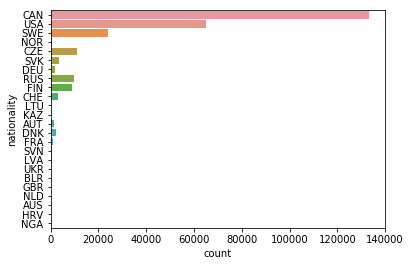

In [101]:
sns.countplot(y=dfNHL.nationality)

### Canadians compose a relatively small portion of total goals scored by all players over all seasons

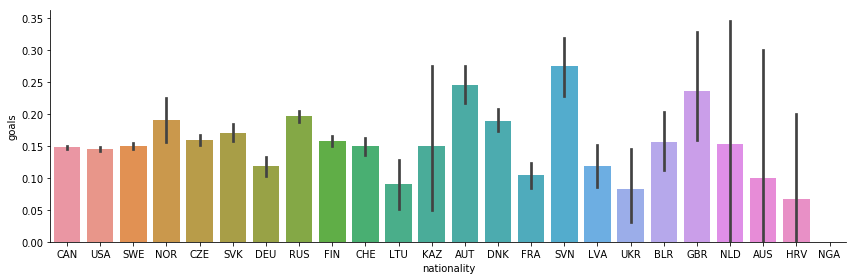

In [102]:
sns.factorplot(x='nationality', y='goals', data=dfNHL, aspect=3, kind='bar')

In [103]:
CANwins = df.groupby(df.team_id)['nationality_CAN','won'].agg(['mean','sum'])

In [104]:
CANwins.columns = [' '.join(col).strip() for col in CANwins.columns.values]

In [105]:
CANwins.head()

,nationality_CAN mean,nationality_CAN sum,won mean,won sum
team_id,,,,
1,0.334171,2791.0,0.424569,3546
2,0.598574,5204.0,0.488613,4248
3,0.427603,4102.0,0.544043,5219
4,0.607276,5225.0,0.474895,4086
5,0.447437,4452.0,0.596784,5938


### Most teams have at least 50% Canadian players

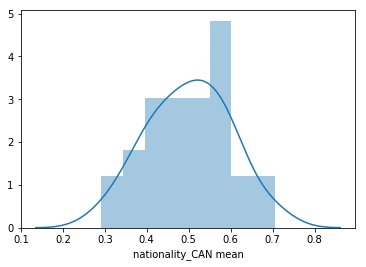

In [106]:
sns.distplot(CANwins['nationality_CAN mean'], bins=8)

In [107]:
CANwins.corr()

,nationality_CAN mean,nationality_CAN sum,won mean,won sum
nationality_CAN mean,1.000000,0.637507,-0.112019,-0.163276
nationality_CAN sum,0.637507,1.000000,-0.001939,0.560841
won mean,-0.112019,-0.001939,1.000000,0.559424
won sum,-0.163276,0.560841,0.559424,1.000000


### Per team over all seasons, as the total count of Canadians increase, average wins decrease

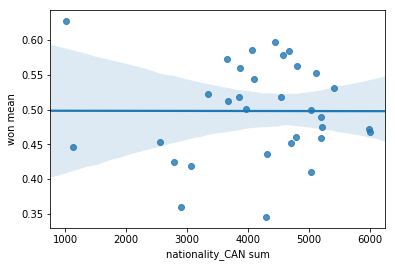

In [108]:
sns.regplot(x='nationality_CAN sum', y='won mean', data=CANwins)

### Per team over all seasons, as the total average count of Canadians increase, average wins decrease

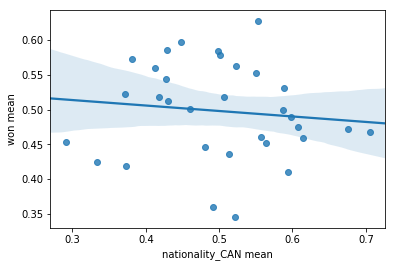

In [109]:
sns.regplot(x='nationality_CAN mean', y='won mean', data=CANwins)

### Per team over all seasons, as the total count of Canadians increase, total wins decrease

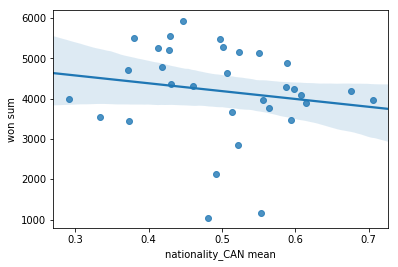

In [110]:
sns.regplot(x='nationality_CAN mean', y='won sum', data=CANwins)

#### **The assumption might be that Canadians are the best at hockey because they compose such a large portion of players per team.**
#### **However, we will interpret that too high a proportion of Canadian players leads to a lack of diversity.**
#### **The managerial insight would be to avoid a team composed of strictly Canadians.**

# **3) What is the best strategy to take at the end of a game with a low plus/minus?**

 A quick refresher on plus/minus:
Plus/minus is a metric designed to measure individual player and overall team performance during a game. A player is awarded a "plus" each time he is on the ice when his team scores an even-strength or shorthanded goal. A player receives a "minus" if he is on the ice for an even-strength or shorthanded goal scored by the opposing team. The only other time a goal can be scored is during a "power-play," when a team has more players on the ice because a member of the other team is in the penalty box for a foul.

First, let us demonstrate that plus/minus is the strongest indicator of winning and find the threshold that guarantees either a win or loss.

In [111]:
dt = tree.DecisionTreeClassifier(max_depth=2)
view = pd.get_dummies(dfNHL, columns=['nationality','primaryPosition', 'settled_in'])
view.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,age,Name,teamName,type,date_time,venue,venueLocation,HoA,won,Points,nationality_AUS,nationality_AUT,nationality_BLR,nationality_CAN,nationality_CHE,nationality_CZE,nationality_DEU,nationality_DNK,nationality_FIN,nationality_FRA,nationality_GBR,nationality_HRV,nationality_KAZ,nationality_LTU,nationality_LVA,nationality_NGA,nationality_NLD,nationality_NOR,nationality_RUS,nationality_SVK,nationality_SVN,nationality_SWE,nationality_UKR,nationality_USA,primaryPosition_C,primaryPosition_D,primaryPosition_LW,primaryPosition_RW,settled_in_OT,settled_in_REG,settled_in_SO
0,2012030221,8471958,3,1925,0,0,0,3,0,0,0,0,0,1,0,0,0,5,0,1406,342,177,35,Dan_Girardi,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
1,2012030221,8471339,3,1597,1,0,2,3,0,0,0,0,0,1,3,0,0,2,1,1099,315,183,34,Ryan_Callahan,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0
2,2012030221,8471873,3,1695,0,0,1,2,0,0,0,0,0,0,0,0,0,2,0,1488,99,108,33,Anton_Stralman,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
3,2012030221,8473432,3,957,0,0,3,5,0,0,2,0,0,0,1,0,0,0,0,957,0,0,33,Derek_Dorsett,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,2012030221,8470192,3,859,0,0,1,0,0,0,2,0,0,1,0,0,0,2,0,859,0,0,36,Steve_Eminger,NY Rangers,P,2013-05-16T23:30:00Z,TD Garden,"Boston, Massachusetts",away,False,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [112]:
# Drop columns with non-integer values and that are not relevant to the analysis
view.drop(columns={'Name','teamName','date_time','venue','venueLocation'},inplace=True)

# Replace type of game with 1.0 for playoff and 0.0 for regular-season
view['type'] = view.type.replace({'P':1.0, 'R':0.0})

# Rename type to isPlayoff
view.rename(columns={'type':'isPlayoff'}, inplace=True)

# Replace home with 1.0 and away with 0.0
view['HoA'] = view.HoA.replace({'home':1.0, 'away':0.0})

# Rename HoA to home 
view.rename(columns={'HoA':'home'}, inplace=True)

In [113]:
# Assign attributes to X and Y to train the decision tree
X = view.drop('won', axis=1)
Y = view.won
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

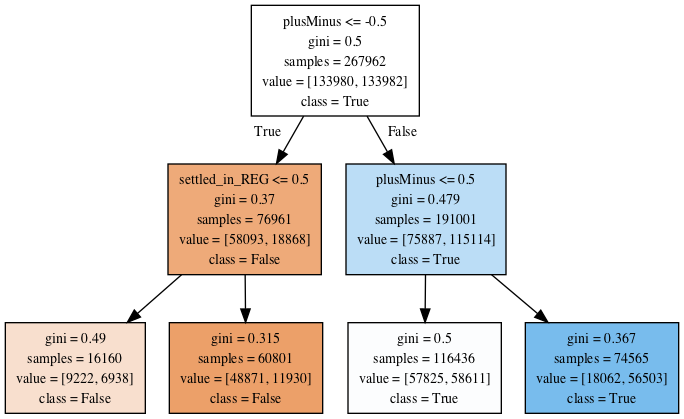

In [114]:
# Train the decision tree with the attributes from X and Y
dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in Y.unique()]
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

This decision tree shows that plus/minus is the strongest indicator of a specific player winning or losing. Additionally, it shows that a player with an overall plus/minus of less than 0.5 cannot win a game settled in regulation - this is logical as a negative plus/minus would result in a loss (unless all goals are scored on a power play) and a 0 plus/minus game at the end of regulation means a game must go to overtime.

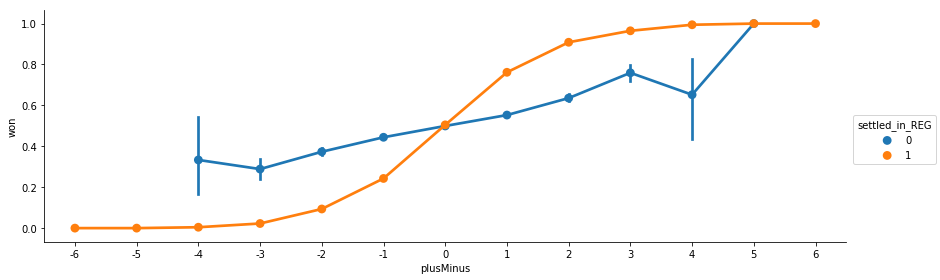

In [115]:
sns.factorplot(x='plusMinus',y='won', hue='settled_in_REG',\
              data=view,aspect=3)

The chart above validates that there are no games ended in regulation time with a 0 or lower plus/minus that have resulted in a win. However, there seems to be an anomaly among -4. How can a player with a plus/minus of -4 have won?

Let us group the data by team and create a new decision tree to try and find the attribute that means a team has won with a negative plus/minus.

In [116]:
view1 = view.groupby(['game_id', 'team_id']).sum()
view1.head()

player_id  timeOnIce  assists  goals  shots  hits  powerPlayGoals  powerPlayAssists  penaltyMinutes  faceOffWins  faceoffTaken  takeaways  giveaways  shortHandedGoals  shortHandedAssists  blocked  plusMinus  evenTimeOnIce  shortHandedTimeOnIce  powerPlayTimeOnIce  age  isPlayoff  home   won  Points  nationality_AUS  nationality_AUT  nationality_BLR  nationality_CAN  nationality_CHE  nationality_CZE  nationality_DEU  nationality_DNK  nationality_FIN  nationality_FRA  nationality_GBR  nationality_HRV  nationality_KAZ  nationality_LTU  nationality_LVA  nationality_NGA  nationality_NLD  nationality_NOR  nationality_RUS  nationality_SVK  nationality_SVN  nationality_SWE  nationality_UKR  nationality_USA  primaryPosition_C  primaryPosition_D  primaryPosition_LW  primaryPosition_RW  settled_in_OT  settled_in_REG  settled_in_SO
game_id    team_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
2012020001 4        152498864      17800        2      1     27    40               0                 0               6           27            62          8         11                 0                   0       12          0          13930                  1012                2858  589        0.0  18.0   0.0       3                0                0                0               13                0                1                0                0                1                0                0                0                0                0                0                0                0                0                0                1                0                1                1                0                  6                  6                   3                   3              0              18              0
           5        152471364      17401        4      3     27    37               2                 3              10           35            62         10          6                 0                   0       12          0          13896                  2260                1245  627        0.0   0.0  18.0       7                0                0                0               13                0                0                0                0                0                0                0                0                0                0                0                0                0                0                1                0                0                0                0                4                  4                  6                   6                   2              0              18              0
2012020002 9        152468321      17286        7      4     37    21               1                 2              14           28            63          5          7                 0                   0       14         15          14002                  2384                 900  622        0.0   0.0  18.0      11                0                0                0               10                0                1                0                1                0                0                0                0                0                0                0                0                0    

In [117]:
# Find the number of unique values in won to determine if the series needs further cleaning.
view1.won.nunique()

5

In [118]:
# Clean the data further by removing any 'won' values less than 0
view1['won'] = view1.won > 0

In [119]:
# Assign attributes to X and Y to train the decision tree 
X = view1.drop('won', axis=1)
Y = view1.won
dt.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

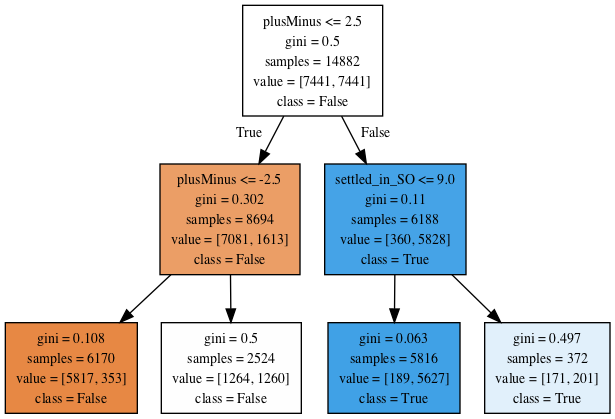

In [120]:
# Train and visualize a decision tree with attributes in X and Y
dt_feature_names = list(X.columns)
dt_target_names = [str(s) for s in Y.unique()]
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

This decision tree clearly shows that the only way to win a game with a negative plus/minus is in a penalty shootout, which takes place after overtime. Let us validate this data with a chart.

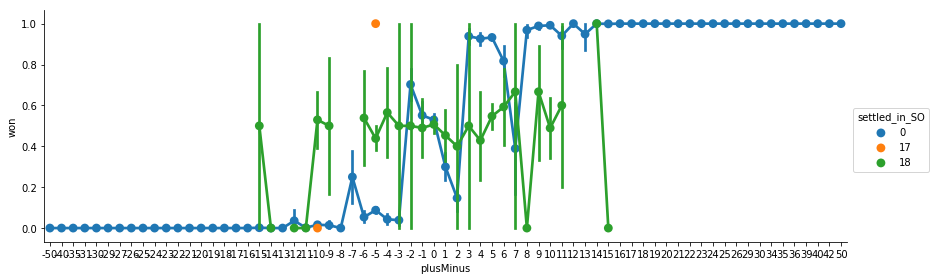

In [121]:
sns.factorplot(x='plusMinus',y='won',hue='settled_in_SO',\
              data=view1,aspect=3)

Wow! It is clear that teams with a negative plus/minus can win through a shootout, but let us use our non-grouped data to create a chart that can more clearly visualize the data.

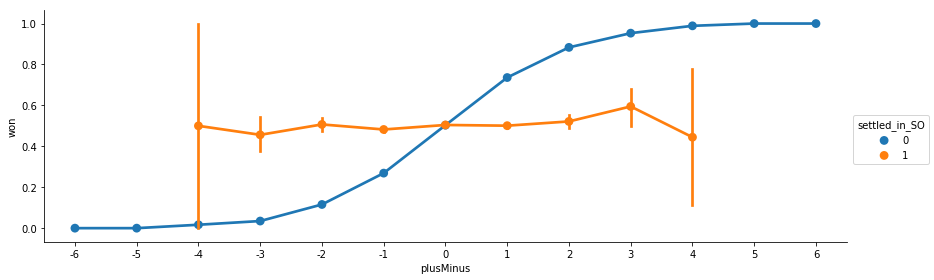

In [122]:
sns.factorplot(x='plusMinus',y='won',hue='settled_in_SO', data=view, aspect=3)

The above chart clearly shows that in a shootout, teams with a negative plus/minus can still win.

#### **Managerial Insight:**
####  **As it is highly unlikely to have a negative plus/minus and be winning, this analysis shows managers that if they have a negative plus/minus at the end of overtime, or even the regular period and the game is tied, the best strategy to take to get a win is to play defensively and aim to reach the penalty shootout. A negative plus/minus and the game being tied means that the other team has been scoring even or shorthanded goals and your team has been scoring power-play goals.**
#### **For example, if the other team scored 2 even-strength goals and your team scored two power-play goals, your plus/minus would be -2 and the score would be tied. If this is the case during overtime of a game, coaches often tell their teams to try and push for another powerplay goal. However, these goals are unlikely because the other team will be more careful committing fouls after already giving up goals in that way. Thus, the best strategy to take in this situation is to play defensively and aim to reach the penalty shootout.**
#### **This can also help conserve player stamina during long playoff series.**